In [213]:
# imports

import random
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import patches
from torch.utils.data import random_split
from torchvision import transforms

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

In [214]:
path = '../project_zip/data'
det_train_path = path + '/detection_train.pt'
det_val_path = path + '/detection_val.pt'
det_test_path = path + '/detection_test.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # change this to cuda if ya want lol

# Model parameters
EPOCHS = 7  # Epochs
BATCH_SIZE = 64  # Batch size
KEEP_PROB = 1  # Dropout

#Optimizer parameters
LR = 1e-3  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-4  # L2 Regularization

models = []
model_names = []
loss_train_list = []
loss_val_list = []

In [215]:
detection_train_data = torch.load(det_train_path)
detection_val_data = torch.load(det_val_path)
detection_test_data = torch.load(det_test_path)

In [216]:
#################################
# Train normalization
train_all = [x for x, _ in detection_train_data]
trainto_one_tensor = torch.stack(train_all)

mean_train = trainto_one_tensor.mean()
std_train = trainto_one_tensor.std()


detection_train_data.transform = transforms.Normalize(mean_train, std_train)

##################################
# Val normalization
val_all = [x for x, _ in detection_val_data]
val_to_one_tensor = torch.stack(val_all)

mean_val = val_to_one_tensor.mean()
std_val = val_to_one_tensor.std()


detection_val_data.transform = transforms.Normalize(mean_val, std_val)

###################################
# Test normalization
test_all = [x for x, _ in detection_test_data]
test_to_one_tensor = torch.stack(test_all)

mean_test = test_to_one_tensor.mean()
std_test = test_to_one_tensor.std()

detection_test_data.transform = transforms.Normalize(mean_test, std_test)

In [217]:
def print_random_img(data):
    x, y = data.__getitem__(random.randint(0, len(data)))
    # (C, H, W)
    print(x.shape)
    tensor_image = transforms.ToPILImage()(x).convert("RGB")
    plt.imshow(tensor_image)
    plt.show()

In [218]:
#print(detection_train_data[0][0].shape)
#print_random_img(detection_train_data)

In [219]:
class Net01(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=120, out_channels=84, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(in_channels=84, out_channels=7, kernel_size=(2, 4)),
        )

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = y.permute(0, 2, 3, 1)

        return y

Shallow Convolutional LeNet5 Model:

In [220]:
class Net02(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=84, kernel_size=5),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=84, out_channels=7, kernel_size=(4, 6)),
        )

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = y.permute(0, 2, 3, 1)

        return y

In [221]:
class Net03(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=240, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=240, out_channels=168, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(in_channels=168, out_channels=84, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer6 = torch.nn.Sequential(
            nn.Conv2d(in_channels=84, out_channels=7, kernel_size=(2, 4)),
        )

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = self.layer6(y)
        y = y.permute(0, 2, 3, 1)

        return y

In [222]:
def myLoss(output, target):
    # Uses BinaryClassification as a  loss function to train the network to recognize if there is a number in the cell or not
    prob = output[:, :1]
    probTarget = target[:, :1]
    loss_fn = nn.BCEWithLogitsLoss()
    loss_prob = loss_fn(prob, probTarget)

    # Creates boolean mask based of if there is a number in the cell and filters out all labels where there is no number
    outputShape = output.shape[1]
    maskOutput = target[:, :1].eq(1).repeat(1, outputShape)
    maskTarget = target[:, :1].eq(1).repeat(1, 6)
    output = torch.masked_select(output, maskOutput)
    target = torch.masked_select(target, maskTarget)
    output = output.reshape(int(output.shape[0] / outputShape), outputShape)
    target = target.reshape(int(target.shape[0] / 6), 6)

    # If there is a number ni the cell it uses MeanSquaredError as a loss function to train the network to find the number's center and its bounding box
    bb = output[:, 1:5]
    bbTarget = target[:, 1:5].to(dtype=torch.double)
    loss_fn = nn.MSELoss()
    loss_bb = loss_fn(bb, bbTarget)

    # If there is a number in the cell it uses CrossEntropy as a loss function to train the network to classify the numbers
    clas = output[:, 5:]
    clasTarget = target[:, 5].to(dtype=torch.long)
    loss_fn = nn.CrossEntropyLoss()
    loss_clas = loss_fn(clas, clasTarget)

    return loss_prob + loss_bb + loss_clas

In [223]:
def train(n_epochs, optimizer, model, train_loader, train_mode):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for imgs, labels in train_loader:
            # We use torch.double to get the same results as Pytorch
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = 0
            for x in range(2):
                for y in range(3):
                    loss += myLoss(outputs[:, x, y, :], labels[:, x, y, :])

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    train_mode.append(losses_train)

Train N-models

In [224]:
train_loader = torch.utils.data.DataLoader(detection_train_data, batch_size=BATCH_SIZE, shuffle=True)
model01 = Net01().to(device=device)
optimizer = optim.Adam(model01.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model01, train_loader, loss_train_list)
models.append(model01)
model_names.append("LeNet Standard")

23:52:18.741118  |  Epoch 1  |  Training loss 8.04562
23:52:28.466548  |  Epoch 2  |  Training loss 7.32372
23:52:39.185280  |  Epoch 3  |  Training loss 6.82792
23:52:49.298869  |  Epoch 4  |  Training loss 6.28328
23:52:57.993499  |  Epoch 5  |  Training loss 5.82814
23:53:06.587300  |  Epoch 6  |  Training loss 5.53797
23:53:15.215003  |  Epoch 7  |  Training loss 5.34697


In [225]:
train_loader = torch.utils.data.DataLoader(detection_train_data, batch_size=BATCH_SIZE, shuffle=True)
model02 = Net02().to(device=device)
optimizer = optim.Adam(model02.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model02, train_loader, loss_train_list)
models.append(model02)
model_names.append("LeNet Shallow")

23:53:19.911378  |  Epoch 1  |  Training loss 7.91928
23:53:24.585039  |  Epoch 2  |  Training loss 7.12608
23:53:29.246676  |  Epoch 3  |  Training loss 6.60220
23:53:33.919232  |  Epoch 4  |  Training loss 6.37257
23:53:38.596110  |  Epoch 5  |  Training loss 6.10387
23:53:43.285514  |  Epoch 6  |  Training loss 5.92927
23:53:47.936111  |  Epoch 7  |  Training loss 5.75709


In [226]:
train_loader = torch.utils.data.DataLoader(detection_train_data, batch_size=BATCH_SIZE, shuffle=True)
model03 = Net03().to(device=device)
optimizer = optim.Adam(model03.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model03, train_loader, loss_train_list)
models.append(model03)
model_names.append("LeNet Deep")

23:54:12.561173  |  Epoch 1  |  Training loss 7.99714
23:54:37.578984  |  Epoch 2  |  Training loss 7.06910
23:55:04.067641  |  Epoch 3  |  Training loss 6.24045
23:55:28.610902  |  Epoch 4  |  Training loss 5.64707
23:56:00.162462  |  Epoch 5  |  Training loss 5.38788
23:56:27.928097  |  Epoch 6  |  Training loss 5.21979
23:56:53.563905  |  Epoch 7  |  Training loss 5.07826


In order to measure our models, we have created this custom accuracy function that can find out how our model performs. This should count the accuracy of the predicted boudning box as well as the predicted class.

    --- IoU code ---

In [227]:
def intersection_over_union(pred_box: torch.tensor, label_box: torch.tensor):
    # pred_box shape should be (N, 4), where N is the number of bboxs
    # label_box shape is (N, 4)

    box1_x1 = pred_box[..., 0:1] - pred_box[..., 2:3] / 2
    box1_y1 = pred_box[..., 1:2] - pred_box[..., 3:4] / 2
    box1_x2 = pred_box[..., 0:1] + pred_box[..., 2:3] / 2
    box1_y2 = pred_box[..., 1:2] + pred_box[..., 3:4] / 2

    box2_x1 = label_box[..., 0:1] - label_box[..., 2:3] / 2
    box2_y1 = label_box[..., 1:2] - label_box[..., 3:4] / 2
    box2_x2 = label_box[..., 0:1] + label_box[..., 2:3] / 2
    box2_y2 = label_box[..., 1:2] + label_box[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [228]:
def find_highest_acc(output):
    output = output.squeeze()
    classes = [x.item() for x in output]

    classes = classes[5:]
    highest_pred = max(classes)
    index = (classes.index(max(classes)))
    # print(f"highest pred: {highest_pred} at {index}")
    return index


def get_vals(tensor: torch.tensor):
    """
    :param tensor:
    :return x, y, w, h:
    """
    tens = tensor[1:5].clone().detach()
    return torch.tensor(
        [(int(tens[0] * 60)) - int((tens[2] / 2) * 60),
         int(tens[1] * 48) - int((tens[3] / 2) * 48),
         int(tens[2] * 60),
         int(tens[3] * 48)],
        dtype=torch.int)


def compute_acc(model, loader):
    correct = 0.
    total = 0.
    IoU = 0
    with torch.no_grad():
        model.eval()
        for imgs, labels in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            output = model(imgs)
            for x in range(2):
                for y in range(3):
                    tensor_ = output[:, x, y, :].squeeze()
                    label_box = labels[:, x, y, :].squeeze()
                    IoU += intersection_over_union(get_vals(label_box), get_vals(tensor_))
                    tensor_[5:] = torch.nn.functional.softmax(tensor_[5:].clone(), dim=0)
                    true_class = int(label_box[-1].item())
                    predicted_class = find_highest_acc(tensor_)
                    if true_class == predicted_class and label_box[0] > 0.67:
                        correct += 1
                        total += 1
                    else:
                        total += 1

    return ((correct + IoU) / total).item()

model_score = []

for i, model in enumerate(models):
    val_load = torch.utils.data.DataLoader(detection_val_data, shuffle=True)
    model_perf = compute_acc(model, val_load) * 100
    print(f"Accuracy of model {i + 1} was: {model_perf}")
    model_score.append(model_perf)
best_model = models[(model_score.index(max(model_score)))]

print(f"Best model was: {best_model}")

Accuracy of model 1 was: 29.20606630977002
Accuracy of model 2 was: 29.192877881242595
Accuracy of model 3 was: 30.360842787817777
Best model was: Net03(
  (layer1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 240, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(240, 168, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (layer5): Sequential(
    (0): Conv2d(168, 84, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout

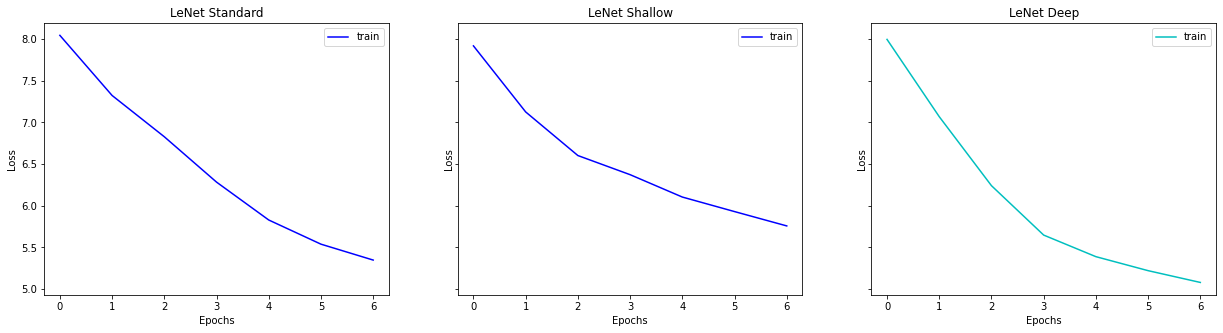

In [229]:
n_model = len(models)

fig, axes = plt.subplots(1, n_model, figsize=(7 * n_model, 5), sharey=True, squeeze=False)

for l_train, name, ax in zip(loss_train_list, model_names, axes.flat):
    ax.plot(l_train, label='train', color=random.choice(['r', 'b', 'y', 'g', 'c', 'm']))
    ax.set_title(str(name))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

In [230]:
"""model_score = []
for i, model in enumerate(models):
    val_load = torch.utils.data.DataLoader(detection_val_data, shuffle=True)
    model_perf = compute_acc(model, val_load) * 100
    model_score.append(model_perf)
    print(f"Accuracy of model {i + 1} was: {model_perf}")
"""

'model_score = []\nfor i, model in enumerate(models):\n    val_load = torch.utils.data.DataLoader(detection_val_data, shuffle=True)\n    model_perf = compute_acc(model, val_load) * 100\n    model_score.append(model_perf)\n    print(f"Accuracy of model {i + 1} was: {model_perf}")\n'

Best model is:

In [231]:
print(best_model)
# Print the model accuracies


Net03(
  (layer1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 240, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(240, 168, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (layer5): Sequential(
    (0): Conv2d(168, 84, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (layer6): Sequential(
    (0): Conv2d(84, 7, kernel_size=(2, 4), stride=(1, 1))
  )
)


Run some examples of the best model below

In [232]:
def draw_bounding_box_man(pan, true_tup, pred_tup, true_w, pred_w, true_h, pred_h):
    fig, ax = plt.subplots(1)
    ax.imshow(pan)
    true_x = true_tup[0]
    true_y = true_tup[1]
    true_bb = patches.Rectangle((true_x, true_y), true_w, true_h, linewidth=3, edgecolor='r',
                                facecolor='none')
    pred_bb = patches.Rectangle((pred_tup[0], pred_tup[1]), pred_w, pred_h, linewidth=3, edgecolor='b',
                                facecolor='none')

    ax.add_patch(true_bb)
    ax.add_patch(pred_bb)

    plt.show()

#todo
- Predicted bounding box / width height - print on picture.
- Is the model correct?
- Mby try other conv - models now that loss function is implemented

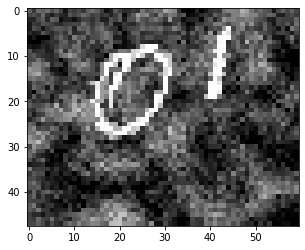

tensor(0., dtype=torch.float32)


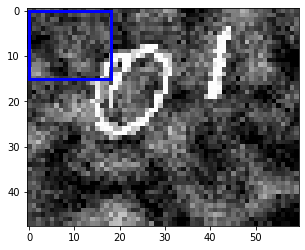

Predicted label is 0
tensor(1., dtype=torch.float32)


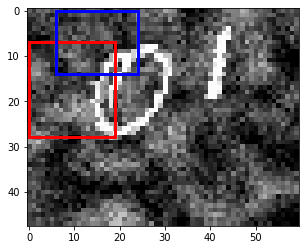

Predicted label is 0
tensor(1., dtype=torch.float32)


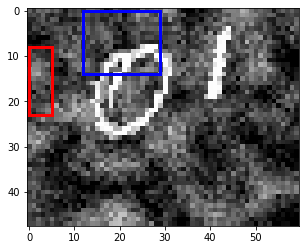

Predicted label is 0
tensor(0., dtype=torch.float32)


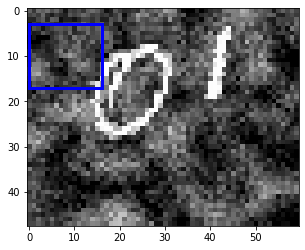

Predicted label is 0
tensor(0., dtype=torch.float32)


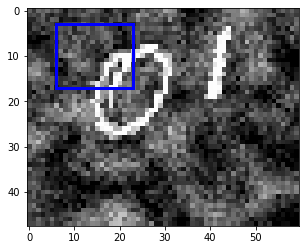

Predicted label is 0
tensor(0., dtype=torch.float32)


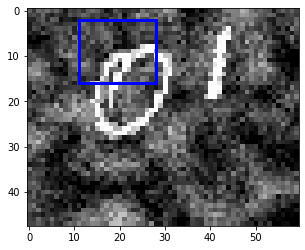

Predicted label is 0


In [233]:
img, label = detection_test_data[random.randint(0, len(detection_val_data))]
img = img.to(device, dtype=torch.double)

tensor_image = transforms.ToPILImage()(img).convert("RGB")
plt.imshow(tensor_image)
plt.show()

# feed image to model
model03.eval()
output = model03(img.unsqueeze(0))

for cel_x in range(2):
    for cel_y in range(3):
        tensor_ = output[:, cel_x, cel_y, :].squeeze()
        label_box = label[cel_x, cel_y, :].squeeze()
        print(label_box[0])
        true_bbox = torch.tensor(
            [(int(label_box[1] * 20) * cel_x) - int((label_box[3] / 2) * 20 * cel_x),
             int(label_box[2] * 24 * cel_y) - int((label_box[4] / 2) * 24 * cel_y),
             int(label_box[3] * 20),
             int(label_box[4] * 24)],
            dtype=torch.float)

        pred_box = torch.tensor(
            [(int(tensor_[1] * 24 * cel_y)) - int((tensor_[3] / 2) * 24 * cel_y),
             int(tensor_[2] * 20 * cel_x) - int((tensor_[4] / 2) * 20 * cel_x),
             int(tensor_[3] * 24),
             int(tensor_[4] * 20)],
            dtype=torch.float)


        draw_bounding_box_man(tensor_image,
                              (true_bbox[0], true_bbox[1]),
                              (pred_box[0], pred_box[1]),
                              true_bbox[2], pred_box[2],
                              true_bbox[3], pred_box[3])
        if tensor_[-1].item() > tensor_[-1].item():
            print("Predicted label is 1")
        else:
            print("Predicted label is 0")


Here is the "best" found model test.

In [234]:
# Accuracy of model - based on test set
test_load = torch.utils.data.DataLoader(detection_test_data, shuffle=True)
model_perf = compute_acc(best_model, test_load) * 100
print(f"Accuracy of model was: {model_perf}")


Accuracy of model was: 31.2638157839501
